# Verify Test Dia Source catalog for Run 1.2p 
Michael Wood-Vasey
Last Verified to Run: 2019-05-06

Performance sanity checking on the DIA Source table from the sample run of one patch.

In [1]:
# Inject gcr-catalogs that supports DIA source into path.
import os
import sys

gcr_catalogs_dir = os.path.join(os.getenv('HOME'), 'local', 'lsst', 'gcr-catalogs')
sys.path.insert(0, gcr_catalogs_dir)

In [2]:
import os

import GCRCatalogs

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

import math
import numpy as np

In [4]:
reader = 'dc2_dia_source_run1.2p_test'
cat = GCRCatalogs.load_catalog(reader)

Questions for this very simple test verification:
1. How many DIA Sources are there?
2. What's the distribution in RA, Dec?
3. What's the mag vs. mag_err plot
4. Can we get out the filter information?

Note that we don't yet of DIA Object table to match this to.

In [5]:
print("There are {} DIA Sources in this test sample".format(len(cat)))

There are 73160 DIA Sources in this test sample


In [6]:
cat.get_quantities('ra')

{'ra': array([53.19682479, 53.20067925, 53.18898265, ..., 53.01645266,
        53.07860929, 53.01999464])}

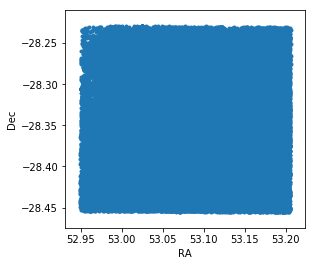

In [7]:
plt.scatter(cat['ra'], cat['dec'], marker='.')
plt.xlabel('RA')
plt.ylabel('Dec')

# While we're doing a rectangular plot of the local tangent, we cn at least get the local scale right
median_ra, median_dec = np.median(cat['ra']), np.median(cat['dec'])
plt.gca().set_aspect(aspect=abs(1/math.cos(median_dec)))

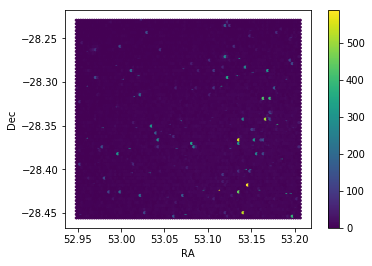

In [8]:
plt.hexbin(cat['ra'], cat['dec'])
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('Dec')

# While we're doing a rectangular plot of the local tangent, we cn at least get the local scale right
median_ra, median_dec = np.median(cat['ra']), np.median(cat['dec'])
plt.gca().set_aspect(aspect=abs(1/math.cos(median_dec)))

In [9]:
cat_r = cat.get_quantities(['ra', 'dec', 'mag', 'mag_err', 'psFlux', 'psFluxErr'],
                           filters=[(lambda x: x == 'r', 'filter'), 'mag_err < 0.1'])

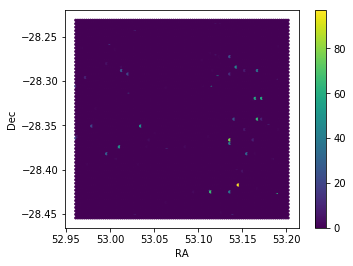

In [10]:
plt.hexbin(cat_r['ra'], cat_r['dec'])
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('Dec')

# While we're doing a rectangular plot of the local tangent, we cn at least get the local scale right
median_ra, median_dec = np.median(cat_r['ra']), np.median(cat_r['dec'])
plt.gca().set_aspect(aspect=abs(1/math.cos(median_dec)))

Text(0,0.5,'mag_err')

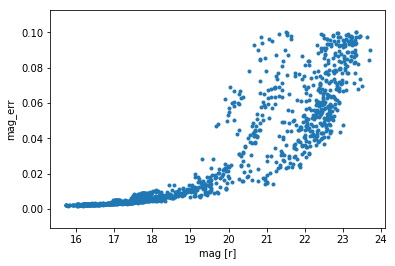

In [11]:
plt.scatter(cat_r['mag'], cat_r['mag_err'], marker='.')
plt.xlabel('mag [r]')
plt.ylabel('mag_err')

In [12]:
cat_by_filter = {}
filter_names = ['u', 'g', 'r', 'i', 'z', 'y']
columns = ['ra', 'dec', 'mag', 'mag_err', 'psFlux', 'psFluxErr']

for f in filter_names: 
    cat_by_filter[f] = cat.get_quantities(columns,
                                          filters=[(lambda x: x == f, 'filter'), 'mag_err < 0.1'])

Text(0,0.5,'mag_err')

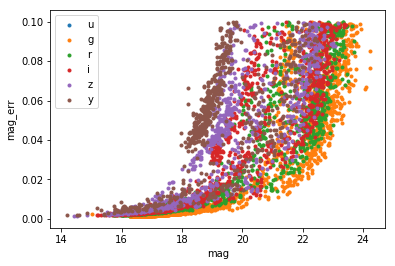

In [13]:
for f, this_cat in cat_by_filter.items():
    plt.scatter(this_cat['mag'], this_cat['mag_err'], marker='.', label=f)

plt.legend()
plt.xlabel('mag')
plt.ylabel('mag_err')

In [14]:
cat.list_all_quantities()

['ixyPSF',
 'I_flag',
 'yErr',
 'dipChi2',
 'filter',
 'totFluxErr',
 'xy_flag',
 'fluxmag0',
 'apFlux_flag',
 'psFlux_flag',
 'totFlux',
 'ra',
 'Ixx',
 'visit',
 'x',
 'IxyPSF',
 'diaSourceId',
 'dipAngle',
 'mag',
 'isDipole',
 'y',
 'apFluxErr',
 'psFluxErr',
 'dec',
 'Ixy',
 'parentDiaSourceId',
 'clean',
 'good',
 'detector',
 'psFlux',
 'Iyy',
 'xErr',
 'magerr',
 'psNdata',
 'apFlux',
 'IxxPSF',
 'IyyPSF']

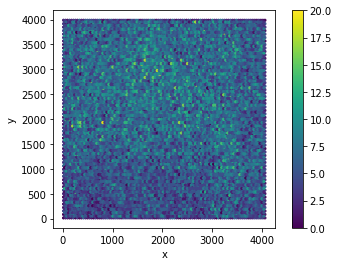

In [15]:
plt.hexbin(cat['x'], cat['y'])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect(aspect=1)